<a href="https://colab.research.google.com/github/SijieQiu/AD_A3/blob/main/Assignment3_AD_Snumber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: LDA Topic Modeling

## Note
Installing Tomotopy locally can return an error, if that's the case run this notebook on Google Colab

## Research Background

LDA is a popular topic modeling algorithm widely used in the fields of Digital Humanities and Social Sciences. In the field of political communication, topic modeling is often applied for analyzing politicians Twitter/X posts, identitying thematic patterns or topics revolving around their posts.

For this assignment, students will work with tweets from two USA politicians, Donald Trump and Bernie Sanders, who are often regarded as right-wing populist and left-wing populist respectively. Right-wing populism often emphasizes nationalism, anti-immigration policies, and a critique of global elites from a culturally conservative perspective, focusing on preserving traditional values and social hierarchies. Left-wing populism prioritizes economic inequality, advocating for the redistribution of wealth, expansion of social services, and empowerment of the working class against the capitalist elite. While both forms of populism appeal to the "common people" against perceived elites and established structures, they diverge significantly in their identification of the elites, proposed solutions, and core ideologies. For a more detailed explanation, you can read the chapter by Macaulay (2019) "Bernie and The Donald: A comparison of left-and right-wing populist discourse" (full reference below).

**Research Questions**
1. What topics are revolving around Donald Trump and Bernie Sanders' posts separately?
2. What are the topic differences between Trump (right-wing popoulist) and Sanders (left-wing populist)?

**Aim:**
1. The first aim of the assignment is to conduct LDA topic modeling. Identify thematic patterns or politics revolving around Trump or Sanders's posts.
2. The second aim is to critically evaluate the results of topic modeling. Try different numbers of topics to see with which settings the topics are more coherent. Critically reflect on the results of LDA topic modeling, discussing them in relation to existing theories about populism.

**Data**
Two datasets are prepared for this assginment. Tweets from Trump and tweets from Sanders. Students are asked to work on these two datasets.

**Methods**
1. Word segamentation
2. Removing stopwords
3. LDA topic modeling
4. Topic evaulation (coherence and human evaluation)
5. Visualization of results.

**References**
1. Macaulay, M. (2019). Bernie and the Donald: A comparison of Left-and Right-wing populist discourse. *Populist discourse: International perspectives*, 165-195.





## Setup

### Q1. Install necessary libraries, including `tomotopy` and `little_mallet_wrapper`, and import them

In [1]:
# Q1 (code)
!pip install tomotopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 31.6 MB/s eta 0:00:00


In [2]:
!pip install little_mallet_wrapper

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import tomotopy as tp
import little_mallet_wrapper
import seaborn
import glob
from pathlib import Path
import pandas as pd

## Data preprocessing

### Q2. Load the two datasets and concatenate them

The goal is to run topic modelling on the combined dataset of Sanders and Trump's tweets

In [46]:
# Q2 (code)
sanders = pd.read_csv('/content/drive/MyDrive/Assignment3/sanders_tweets.csv', encoding="UTF-8")
trump = pd.read_csv('/content/drive/MyDrive/Assignment3/trump_tweets.csv', encoding="UTF-8")
tweets = pd.concat([sanders, trump])

In [63]:
tweets.head()

,Username,TweetId,Title,Content
0,SenSanders,1351670845639421952,SenSanders_1351670845639421952,Wealth increase in past 10 months:\n⬆️$173 bil...
1,SenSanders,1351259762722279424,SenSanders_1351259762722279424,Amidst massive income and wealth inequality te...
2,SenSanders,1351242822293319680,SenSanders_1351242822293319680,"“We now have the resources, we now have the sk..."
3,SenSanders,1350885541911400448,SenSanders_1350885541911400448,"After surviving an attempt on his life, Russia..."
4,SenSanders,1349880150041780224,SenSanders_1349880150041780224,President-Elect Biden's COVID rescue plan will...


### Q3. Clean the data

Transform all tweets to lowercase, remove stopwords, punctuation, and numbers. Add the processed text to a list called `training_data`.
Create a list with the content of the tweets (`original_texts`) and a list that allows you to identify both the author of the tweet and its ID (`titles`).


In [64]:
# Q3 (code)
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import string

nltk.download('stopwords')

def preprocess_text(text):
    # Convert text to lowercase
    processed_text = text.lower()
    # Remove URLs and user mentions
    processed_text = re.sub(r"http\S+|www\S+|https\S+|\/\/t|co\/|\@\w+", '', processed_text, flags=re.MULTILINE)
    # Remove punctuation
    processed_text = processed_text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    processed_text = re.sub(r'\d+', '', processed_text)
    # Tokenize the text
    words = processed_text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    # Join the filtered words back into a string
    processed_text = ' '.join(filtered_words)

    return processed_text

training_data = []
original_texts = []
titles = []

for index, row in tweets.iterrows():
    # Preprocess the tweet text
    processed_text = preprocess_text(row['Content'])
    # Add the processed text to the 'training_data' list
    training_data.append(processed_text)
    # Add the original text to the 'original_texts' list
    original_texts.append(row['Content'])
    # Create the title by combining 'Username' and 'TweetId'
    title = row['Username'] + '_' + str(row['TweetId'])
    # Add the title to the 'titles' list
    titles.append(title)

# Tip: add the following line to remove URLS and user mentions
processed_text = re.sub(r"http\S+|www\S+|https\S+|\/\/t|co\/|\@\w+|realdonaldtrump", '', processed_text, flags=re.MULTILINE)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
len(training_data), len(original_texts), len(titles)

(30371, 30371, 30371)

## LDA topic modelling

### Q4. Train a an LDA topic model with `tomotopy`

In [66]:
# Q4 (code)
# Number of topics to return
num_topics = 10
# Numer of topic words to print out
num_topic_words = 10

# Intialize the model
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

Topic Model Training...


Iteration: 0	Log-likelihood: -9.297291474369114
Iteration: 10	Log-likelihood: -8.935073826865052
Iteration: 20	Log-likelihood: -8.764202923064156
Iteration: 30	Log-likelihood: -8.684578367261611
Iteration: 40	Log-likelihood: -8.638394846159006
Iteration: 50	Log-likelihood: -8.602689082022001
Iteration: 60	Log-likelihood: -8.577216279125617
Iteration: 70	Log-likelihood: -8.56057267131274
Iteration: 80	Log-likelihood: -8.54423703114394
Iteration: 90	Log-likelihood: -8.532579030876692


### Q5. Print out the top words for each topic and manually evaluate their coherence


In [67]:
# Q5a (code)
topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")

✨Topic 0✨

us china border states united amp trade deal many great

✨Topic 1✨

great thank state amp vote america job rt endorsement total

✨Topic 2✨

must people change country drug need us government climate american

✨Topic 3✨

rt american us senate amp people war today congress must

✨Topic 4✨

rt amp democrats impeachment president trump fbi russia never witch

✨Topic 5✨

rt president trump today great new live pm thank history

✨Topic 6✨

rt trump biden president joe court supreme watch judge says

✨Topic 7✨

workers pay jobs tax wage taxes million billion corporations american

✨Topic 8✨

news fake amp people media democrats great election republican never

✨Topic 9✨

health care people tax right americans country million make need



In [ ]:
# Q5b (words)
# Describe what each topic is about. What ideas, values, or situations do these keywords refer to?

1. **Topic 0: US-China Trade Relations**
   - This topic seems to focus on the relationship between the United States and China, particularly regarding trade deals and possibly border disputes or negotiations between the two countries.

2. **Topic 1: Political Endorsements and Thankfulness**
   - This topic appears to involve expressions of gratitude, political endorsements, and possibly discussions about voting in America. It may also touch on job creation and the state of the nation.

3. **Topic 2: Social and Political Change**
   - This topic revolves around the need for change in various aspects of society and government, such as drug policy, climate action, and societal reforms. It suggests a call for transformative actions.

4. **Topic 3: American Politics and Government**
   - This topic seems to focus on American political institutions and processes, including discussions about the American Senate, wars, and congressional activities. It reflects ongoing political debates and events.

5. **Topic 4: Trump, Democrats, and Impeachment**
   - This topic involves discussions related to President Trump, the Democratic Party, and issues such as impeachment, Russia, and FBI investigations. It reflects political controversies and partisan divisions.

6. **Topic 5: President Trump's Actions and Speeches**
   - This topic appears to cover President Trump's actions, speeches, and events related to his presidency. It may include discussions about his leadership, decisions, and public appearances.

7. **Topic 6: Trump vs. Biden and Supreme Court**
   - This topic involves discussions about President Trump and former Vice President Joe Biden, possibly related to their positions on the Supreme Court or statements made by either candidate.

8. **Topic 7: Economic Issues and Taxation**
   - This topic focuses on economic issues such as workers' wages, taxes, job creation, and the role of corporations in society. It reflects concerns about economic inequality and taxation policies.

9. **Topic 8: Fake News and Media Bias**
   - This topic involves discussions about fake news, media bias, and the role of media in politics. It may reflect concerns about misinformation, media credibility, and political narratives.

10. **Topic 9: Healthcare and Taxation**
    - This topic seems to revolve around discussions regarding healthcare, tax policies, and rights of Americans. It may involve debates about healthcare access, tax burdens, and societal priorities.

## Topic coherence

Use `tomotopy`'s [`.coherence()`](https://bab2min.github.io/tomotopy/v0.10.0/en/coherence.html) function to automatically calculate the topic coherence.

The coherence value can vary from `0` (no coherence) to `1` (maximum coherence). Interpret the results and, if needed, retrain the model using a different number of topics.

In [68]:
# There are different metrics for coherence, we choose `c_v`

coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.5520101986080408 
Per Topic: [0.5349108904600144, 0.5367374449968338, 0.5037892371416092, 0.41509464010596275, 0.6283024460077286, 0.4332566067576408, 0.5770998775959015, 0.6903407394886016, 0.5730366021394729, 0.6275335013866424]



### Q6. Interpret topic coherence

Report the following:
- number of topics you initially used to train the model and the coherence score you got
- changes made to the number of topics and new coherence scores obtained

In [ ]:
# Q6 (words)

**The number of topics I initially used to train the model was 10, and the coherence score I got was 0.5520101986080408.**

After altering the number of topics to 13, 16, 18, 20, and 22, it was observed that the coherence score reached its highest value of 0.5733 when the number of topics was set to 22. Subsequent attempts to adjust the number of topics to 21 and 23 yielded lower coherence scores. This suggests that the optimal number of topics for the model is 22, as it maximizes the coherence of the topic model.

**Following are the results:**

**num_topics:13**

Average: 0.5538478952904161

Per Topic: [0.5994509130716323, 0.5708537340164185, 0.6318961083889008, 0.668990483880043, 0.45084454119205475, 0.6397465318441391, 0.4472872272133827, 0.5081759184598923, 0.565880224108696, 0.47769886180758475, 0.4696883769705892, 0.6605536133050919, 0.508956104516983]

**num_topics:16**

Average: 0.5569553945562802

Per Topic: [0.5554518640041352, 0.5971392780542374, 0.47604030817747117, 0.6407271057367325, 0.5266951739788055, 0.5744285464286805, 0.6189310312271118, 0.5323899775743485, 0.435080449283123, 0.586472462117672, 0.5291220545768738, 0.6749957621097564, 0.41022844016551974, 0.5404532572254539, 0.5299433052539826, 0.6831872969865799]

**num_topics:18**

Average: 0.5395972231196033

Per Topic: [0.5372770339250564, 0.4643555819988251, 0.5211788386106491, 0.4739909917116165, 0.4535584270954132, 0.45911138206720353, 0.5710760056972504, 0.668874180316925, 0.5079109981656075, 0.7217900156974792, 0.4630494087934494, 0.597206161916256, 0.5415378302335739, 0.45882118344306944, 0.5613591998815537, 0.41983142495155334, 0.6726507633924484, 0.6191705882549285]

**num_topics：20**

Average: 0.5596457321941852

Per Topic: [0.5398014321923256, 0.5608913719654083, 0.5305775597691536, 0.6287542343139648, 0.6071519453078509, 0.479144474864006, 0.5001034677028656, 0.5428879544138908, 0.6983791559934616, 0.5591143250465394, 0.459585565328598, 0.5371241003274918, 0.7000618726015091, 0.4773800767958164, 0.4957826226949692, 0.4958553213626146, 0.5782772094011307, 0.6785948902368546, 0.4887423187494278, 0.6347047448158264]

**num_topics:21**

Average: 0.5664327463988835

Per Topic: [0.7459445148706436, 0.4376986399292946, 0.6318632364273071, 0.500975352525711, 0.5466929107904435, 0.487084574252367, 0.5457555651664734, 0.6381241634488106, 0.5981608414324, 0.545262160897255, 0.6633621543645859, 0.5606301292777062, 0.5770273298025131, 0.561343415081501, 0.555429445952177, 0.5709655284881592, 0.4091973155736923, 0.6149179339408875, 0.5995895273983478, 0.5660812497138977, 0.5389816850423813]

**num_topics:22**

Average: 0.5733154151588679

Per Topic: [0.6332969754934311, 0.6331113427877426, 0.5174940288066864, 0.6376898273825645, 0.702876877784729, 0.5620267301797867, 0.5253467373549938, 0.6829146981239319, 0.4255083456635475, 0.5956763416528702, 0.6012605965137482, 0.5734421133995056, 0.5014810591936112, 0.5021392911672592, 0.5074971571564675, 0.7310245633125305, 0.40925407558679583, 0.49878640174865724, 0.5406491965055465, 0.6859105944633483, 0.5683892458677292, 0.5771629333496093]

**num_topics:23**

Average: 0.5373404207396443

Per Topic: [0.5115965574979782, 0.5142771322280169, 0.5581180572509765, 0.5515114068984985, 0.516429354250431, 0.4495981365442276, 0.4950704097747803, 0.5866176366806031, 0.5023645140230656, 0.40404043793678285, 0.4947852224111557, 0.4183408613316715, 0.5333793722093105, 0.6494155466556549, 0.5636344760656357, 0.45730904340744016, 0.5111720874905586, 0.6587822735309601, 0.5863196611404419, 0.464233273267746, 0.7527642324566841, 0.45785392820835114, 0.7212160557508469]

### X1. Optional question 1
(This question is not compulsory, it only allows you to get an extra point.)

Create a function to plot the average coherence for models with different number of topics.

In [ ]:
# X1 (code)
# Tip: y = average topic coherence; x = number of topics in the model

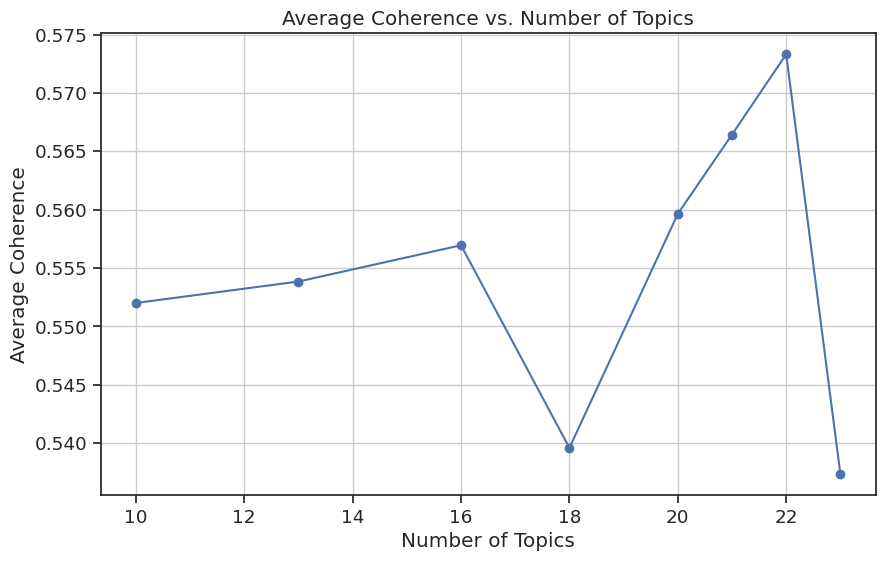

In [122]:
import matplotlib.pyplot as plt

def plot_coherence(num_topics_list, coherence_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(num_topics_list, coherence_scores, marker='o', linestyle='-')
    plt.title('Average Coherence vs. Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Average Coherence')
    plt.grid(True)
    plt.show()

num_topics_list = [10, 13, 16, 18, 20, 21, 22, 23]
coherence_scores = [0.5520101986080408, 0.5538478952904161, 0.5569553945562802, 0.5395972231196033, 0.5596457321941852, 0.5664327463988835, 0.5733154151588679, 0.5373404207396443]

plot_coherence(num_topics_list, coherence_scores)


### Q7. Topic distributions
Calculate the topic distributions for all tweets and get the top documents for some topics (between 2 and 5) that you think could be more representative of Sanders or Trump.

In [87]:
# Q7a (code)
# Based on Q6's findings, I use topic numbers = 22 to train the model now
# Number of topics to return
num_topics = 22
# Numer of topic words to print out
num_topic_words = 10

# Intialize the model
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")

Topic Model Training...


Iteration: 0	Log-likelihood: -9.546569514955815
Iteration: 10	Log-likelihood: -9.078655136735724
Iteration: 20	Log-likelihood: -8.879705492108265
Iteration: 30	Log-likelihood: -8.772855953935121
Iteration: 40	Log-likelihood: -8.701686080963828
Iteration: 50	Log-likelihood: -8.655522156917757
Iteration: 60	Log-likelihood: -8.617171138709807
Iteration: 70	Log-likelihood: -8.590621162541023
Iteration: 80	Log-likelihood: -8.563646358624563
Iteration: 90	Log-likelihood: -8.544955286289284
✨Topic 0✨

new york amp times rt minister prime many hillary clinton

✨Topic 1✨

ever years economy history jobs rt amp since record best

✨Topic 2✨

rt drug prices americans covid coronavirus must price companies prescription

✨Topic 3✨

health care right country every people states united world must

✨Topic 4✨

rt great today america thank american president day honor women

✨Topic 5✨

people health care americans need make millions must security republicans

✨Topic 6✨

great th

In [88]:
topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]

In [89]:
from IPython.display import Markdown, display
import re

def make_md(string):
    display(Markdown(str(string)))

def get_top_docs(docs, topic_distributions, topic_index, n=5):

    sorted_data = sorted([(_distribution[topic_index], _document)
                          for _distribution, _document
                          in zip(topic_distributions, docs)], reverse=True)

    topic_words = topics[topic_index]

    make_md(f"### ✨Topic {topic_index}✨\n\n{topic_words}\n\n")
    print("---")

    for probability, doc in sorted_data[:n]:
        # Make topic words bolded
        for word in topic_words.split():
            if word in doc.lower():
                doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE)

        make_md(f'✨  \n**Topic Probability**: {probability}  \n**Document**: {doc}\n\n')

    return

In [116]:
get_top_docs(titles, topic_distributions, topic_index=21, n=6)

### ✨Topic 21✨

workers tax pay wage billion million taxes wealth americans federal



---


✨  
**Topic Probability**: 0.9330377578735352  
**Document**: SenSanders_1161271159566077952



✨  
**Topic Probability**: 0.9245755076408386  
**Document**: SenSanders_1351670845639421952



✨  
**Topic Probability**: 0.9191111922264099  
**Document**: SenSanders_986430246722392064



✨  
**Topic Probability**: 0.9191111922264099  
**Document**: SenSanders_1202287585684529152



✨  
**Topic Probability**: 0.9156005382537842  
**Document**: SenSanders_1018133766596853760



✨  
**Topic Probability**: 0.9029666185379028  
**Document**: SenSanders_989512930013138944



Interpret the results above. Are there topics that have top tweets only by one politician? Why do you think these topics are more representative of one of the two politicians' views?

In [ ]:
# Q7b (words)

The analysis reveals that certain topics predominantly feature tweets from either Trump or Sanders, while others have a mix of both politicians' tweets. Specifically, topics 0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 16, 18, 19, and 20 consist solely of tweets by Trump. Conversely, topics 5, 13, 14, 17, and 21 exclusively contain tweets from Sanders.

Moreover, in topics 2 and 15, there is a minor presence of the other politician's tweets alongside the dominant politician's tweets. For example, topic 2 features one tweet by Trump and five tweets by Sanders, while topic 15 comprises four tweets by Sanders and two tweets by Trump. This suggests that these topics primarily represent the viewpoints of the politician whose tweets dominate the topic, with minimal contributions from the other politician.

In my opinion, Topic 6 could most represent Trump's point of view. This topic contains tweets expressing gratitude ("great thank"), referencing the Republican Party ("Republican"), and mentioning events or occasions ("night," "last," "one"). These elements are consistent with Trump's style of communication and his emphasis on highlighting accomplishments, expressing appreciation, and rallying support from his political base.

Similarly, Topic 5 could most represent Sanders' point of view. This topic includes tweets discussing healthcare ("health care"), the needs of the American people ("people health care americans need"), and security ("must security republicans"). These themes align closely with Sanders' policy priorities, which often focus on healthcare reform, economic security, and social justice issues that resonate with his progressive agenda and political messaging.

## Large scale analysis

### Q8. Create a random sample of the whole dataset and visualize the topic distributions for the sampled tweets

In [117]:
# Crete a sample of tweets

from random import sample

target_labels = sample(titles,100)

In [118]:
# Q8 (code)
# Create a heatmap using the random sample
# Tip: to display more than 20 tweets you have to change the values of `dim =` in sns.heatmap()
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', font_scale=1.2)
def plot_categories_by_topics_heatmap(labels,
                                      topic_distributions,
                                      topic_keys,
                                      output_path=None,
                                      target_labels=None,
                                      color_map = sns.cm.rocket_r,
                                      dim=None):

    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category',
                                     columns='Topic',
                                     values='Probability')
    df_norm_col=(df_wide-df_wide.mean())/df_wide.std()

    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_col, cmap=color_map)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    plt.show()

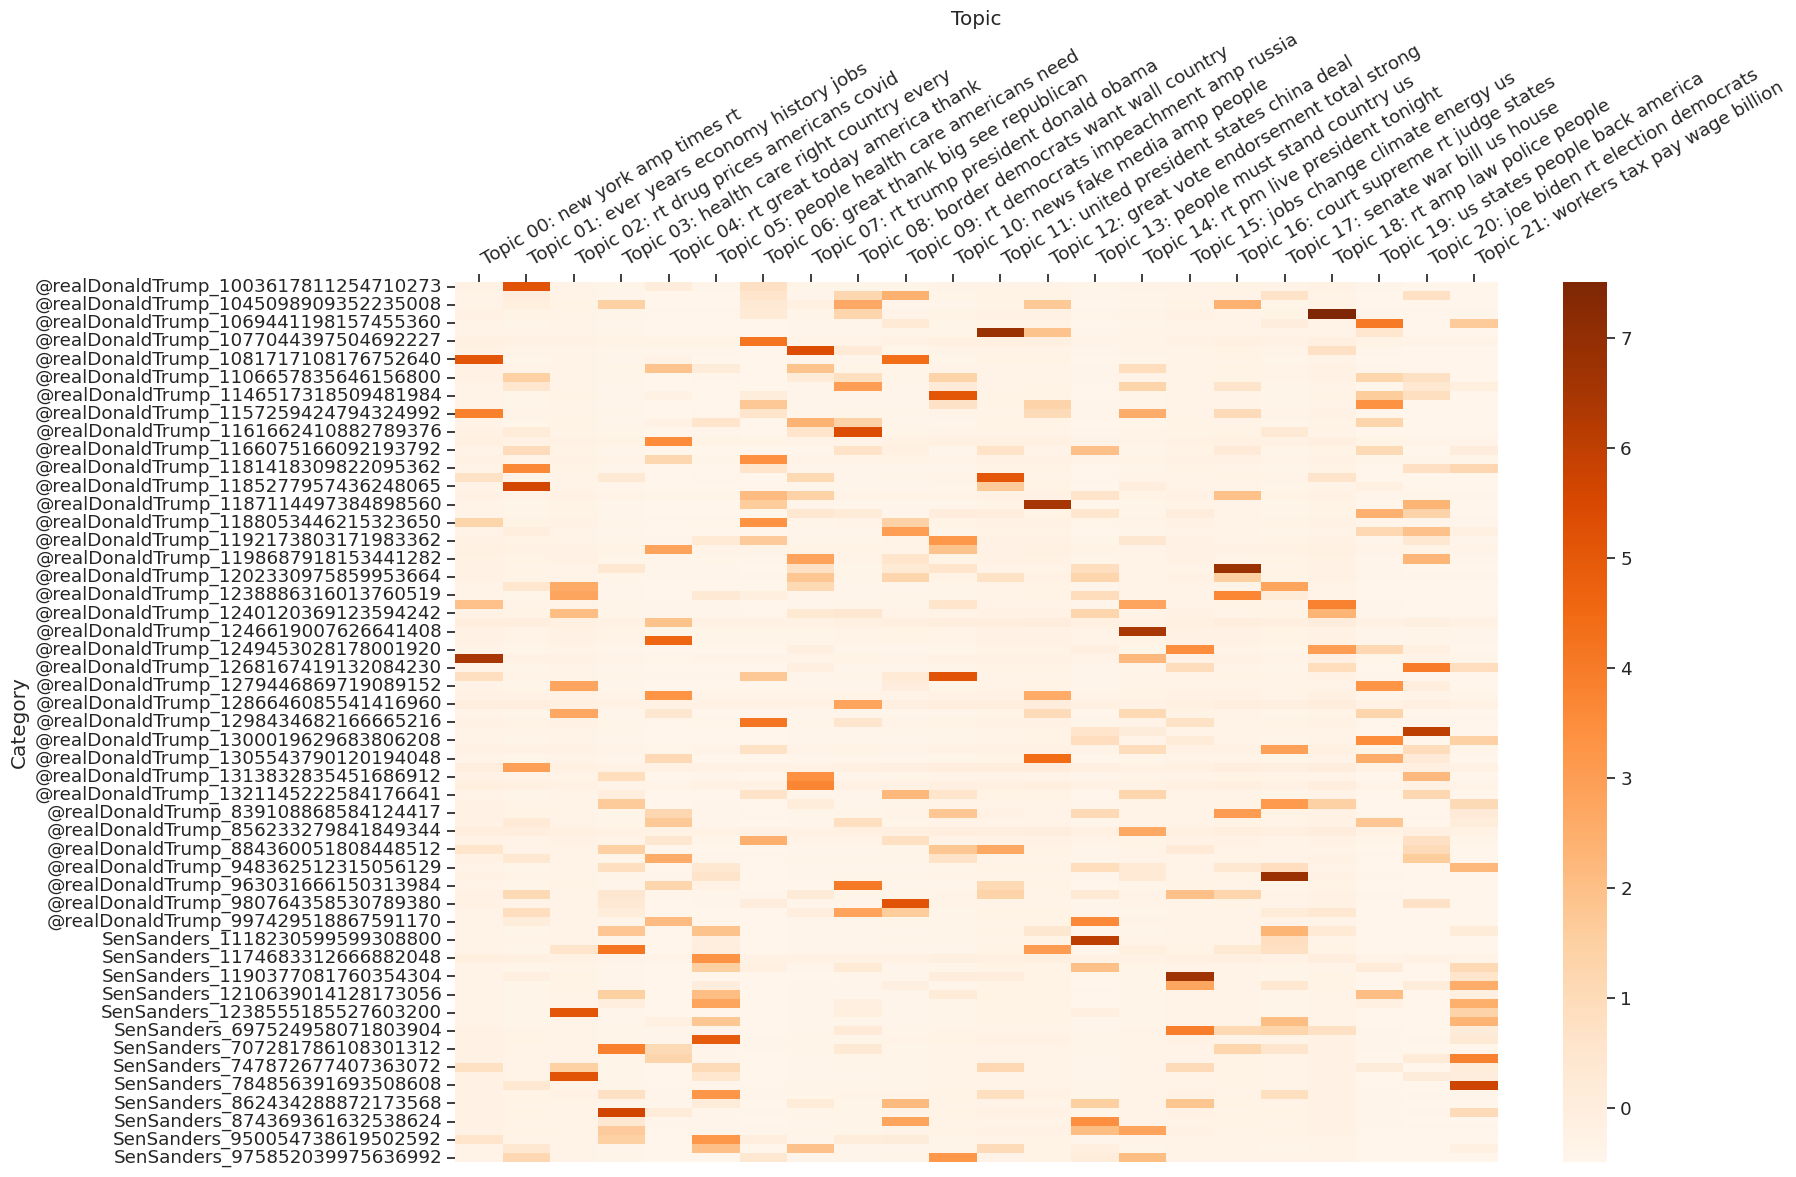

In [121]:
plot_categories_by_topics_heatmap(titles,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=target_labels,
                                  color_map = 'Oranges',
                                 dim=(18,12))

### Q9. Interpret the heatmap
Do you see any pattern in the probability distributions of topics for each politician?

Are there topics that are more likely for one of the two politicians?

In [ ]:
# Q9 (words)

From the heat map, we observe that the number of Trump's tweets surpasses that of Sanders', suggesting Trump's higher frequency of tweeting. This observation, coupled with the random selection of tweets from the dataset, implies Trump's greater inclination towards tweeting compared to Sanders. As discussed in Q7b, the darkest segments of Topics 5, 13, 15, 17, and 21 predominantly consist of Sanders' tweets, corroborating our inference that these topics are more closely associated with Sanders.

However, there are exceptions such as Topics 2 and 3, where the color intensity is also notable. Concerning Trump, the darkest segments are found in Topic 18, featuring words like "law" and "policy" that align with Trump's rhetoric and policy priorities. Trump frequently emphasizes themes such as "Law and Order Focus," "Support for Law Enforcement," and "References to American Values" in his speeches, further reinforcing his association with this topic.

### X2. Optional question 2
(This question is not compulsory, it only allows you to get an extra point)

Make the sample balanced, with 50 tweets by Trump and 50 by Sanders.

In [ ]:
# X2 (code)


### X3. Optional question 3
(This question is not compulsory, it only allows you to get an extra point)

Extend the analysis to all the tweets in the dataset.

In [ ]:
# X3 (code and words)
# Tip: plotting a heatmap for thousands of tweets is not practical.
# Make a comparison based on the numerical values in the `df_norm_col` dataframe (see Week 6 notebook)